In [1]:
import random
import numpy as np
import json
from PIL import Image, ImageFilter
import glob
import math

import chainer
from chainer import datasets
import chainer.functions as F
import chainer.links as L

import pylab as plt
import matplotlib.pyplot as plt


7390


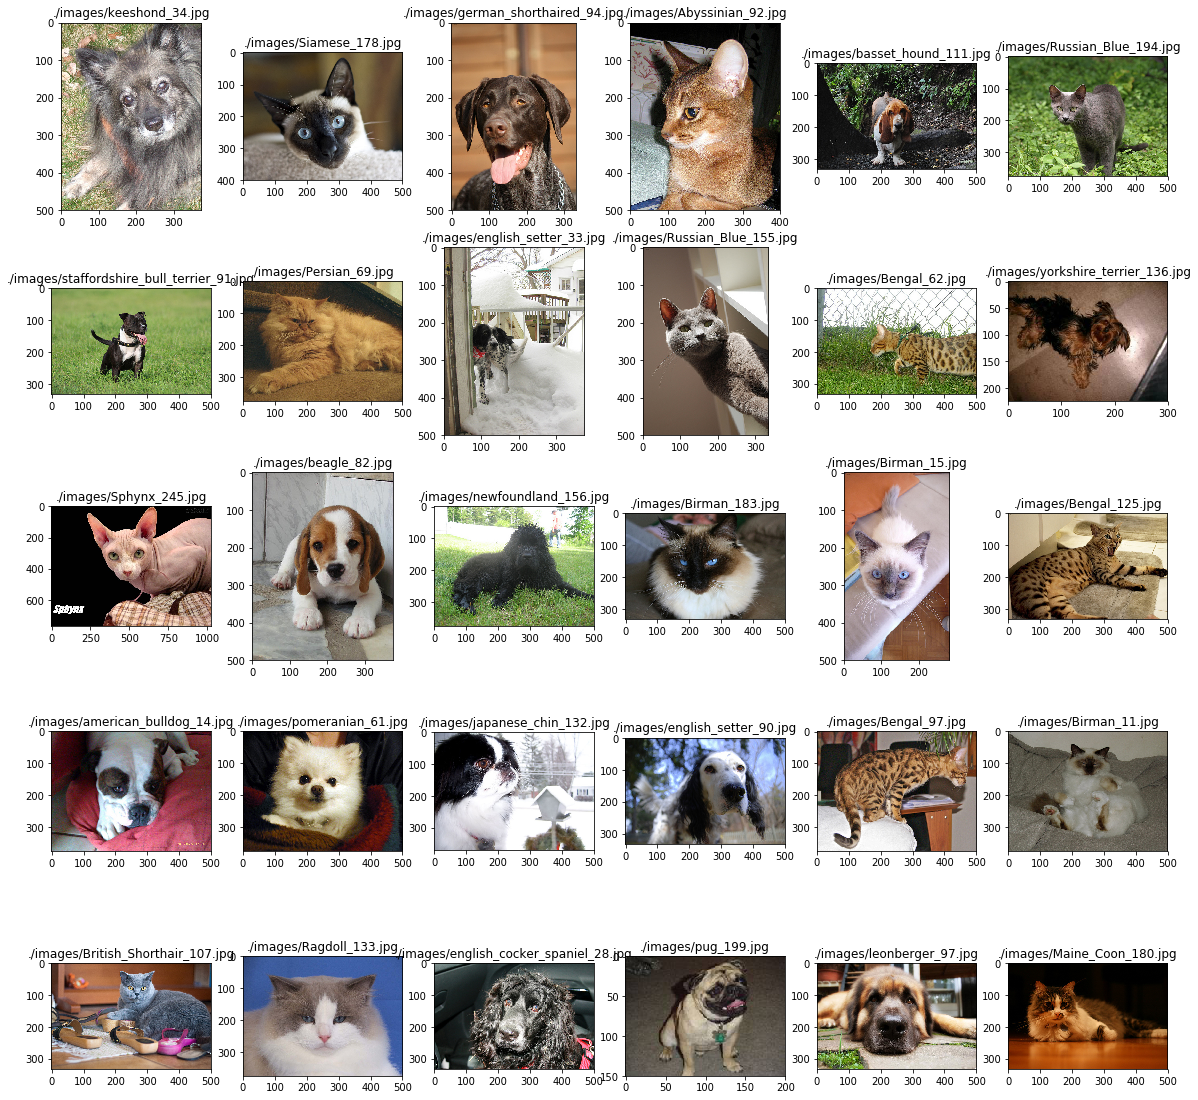

In [2]:
#Get list of image
image_file = glob.glob('./images/*.jpg')
print(len(image_file))
plt.figure(figsize = (20, 20))
for k in range(30):
    img = Image.open(image_file[k])
    plt.subplot(5, 6, k+1)
    plt.title(image_file[k])
    plt.imshow(img)

In [3]:
img.size

(500, 333)

In [3]:
import os

root = os.getcwd()
print(root)
files = root + '/images'
os.chdir(files)

/home/ubuntu/Pets


In [38]:
class PetTrainDataset(chainer.dataset.DatasetMixin):
    def __init__(self):
        self.train_data = []
        self.train_label = []
        self.t2inds = {}
        f = open('train.json')
        train_json = json.load(f)
        
        count = 0
        for i in train_json.keys():#class id
            if i =='cat':
                class_id = 0
            else:
                class_id = 1
                
            for j in train_json[i].keys(): #breed id
                train_ind = train_json[i][j]['images']
                    
                for k in train_ind:#name
                    img_file = k + '.jpg'
                    train_img = Image.open(img_file).convert('RGB')
                    #img = load_image(img_file, augmentation=True)
                    #train_img.append(img)
                    
                    #---augmentation---
                    #color augmentation
                    #train_img = transforms.pca_lighting(train_img, 76.5) #76.5:  sigma (float) – Standard deviation of the Gaussian. In the original paper, this value is 10% of the range of intensity
 
                    #standardization
                    #train_img -= mean[:, None, None]  #only do standardization to test_img
                    #train_img /= std[:, None, None]
 
                    #random flip, expend, rotate and crop
                    #train_img = transforms.random_flip(train_img, x_random=True) #x_random-Randomly flip in horizontal direction
                    #train_img = transforms.random_expand(train_img, max_ratio=1.5)
                    #train_img = transforms.random_rotate(train_img)
                    #train_img = transforms.random_crop(train_img, (224, 224))
                                     
                    
                    x_center = train_img.size[0] // 2
                    y_center = train_img.size[1] // 2
                    half_short_side = min(x_center, y_center)
                    x0 = x_center - half_short_side
                    y0 = y_center - half_short_side
                    x1 = x_center + half_short_side
                    y1 = y_center + half_short_side
                    
                    # rotation
                    if np.random.random() > 0.5:
                        angle = np.random.randint(-10, 10)
                        train_img = train_img.rotate(angle, resample=Image.BILINEAR)
                    # flip
                    if np.random.random() > 0.5:
                        train_img = train_img.transpose(Image.FLIP_LEFT_RIGHT)
                    # shift and scaling
                    if np.random.random() > 0.5:
                        range_x = train_img.size[0] // 10
                        range_y = train_img.size[1] // 10
                        x0 = max(0, np.random.randint(x0 - range_x, x0 + range_x))
                        y0 = max(0, np.random.randint(y0 - range_y, y0 + range_y))
                        x1 = min(train_img.size[0], np.random.randint(x1 - range_x, x1 + range_x))
                        y1 = min(train_img.size[1], np.random.randint(y1 - range_y, y1 + range_y))
                    #train_img = train_img.resize((224, 224), Image.ANTIALIAS)
                    train_img = train_img.crop((x0, y0, x1, y1))
                    
                    train_img = L.model.vision.resnet.prepare(train_img) #converts given images to numpy array for resnet
                    train_img = train_img[np.newaxis]
                    
                    if class_id not in self.t2inds:
                        self.t2inds[class_id] = []
                    
                    self.train_data.append(train_img)
                    self.train_label.append(class_id)
                    self.t2inds[class_id].append(count)
                    count += 1
        #print(type(self.train_data))
            
        self.train_data = np.array(self.train_data, dtype=np.float32)
        self.train_label = np.array(self.train_label, dtype=np.int32)
        
    def __len__(self):
        return len(self.train_label)
        
    def get_example(self, i):
         #x = self.train_data[i].reshape(3, 224, 224)
        #label0 = self.train_label
       
        #input 1
        label0 = np.random.choice(self.train_label)
        x_t = np.random.choice(self.t2inds[label0])
        x = self.train_data[x_t].reshape(3, 224, 224)
            
        #input 2
        label = np.random.choice(self.train_label)
        y_t = np.random.choice(self.t2inds[label])
        y = self.train_data[y_t].reshape(3, 224, 224)
        

        if int(self.train_label[x_t]) == int(self.train_label[y_t]):
            t = 1
        else:
            t = 0
            
        return x, y, t

In [ ]:
        #x = self.train_data[i].reshape(3, 224, 224)
        #ind = np.random.choice(self.train_label[i])
        #x_t = np.random.choice(self.t2inds[ind])
        #y_t = np.random.choice(self.t2inds[ind])
        #x = self.train_data[x_t].reshape(3, 224, 224)
        #y = self.train_data[y_t].reshape(3, 224, 224)
        
        #label = np.random.choice(self.train_label[self.train_label != t])
        #ind_x = np.random.choice(self.t2inds[label])
        #ind_y = np.random.choice(self.t2inds[label])
        #x = self.train_data[ind_x].reshape(3, 224, 224)
        #y = self.train_data[ind_y].reshape(3, 224, 224)

In [89]:
class PetTestDataset(chainer.dataset.DatasetMixin):
    def __init__(self):
        self.test_data = []
        self.test_label = []
        self.t2inds = {}
        f = open('./test.json')
        test_json = json.load(f)
        
        count = 0
        for i in test_json.keys():#class id
            if i =='cat':
                class_id = 0
            else:
                class_id = 1
                
            for j in test_json[i].keys(): #breed id
                test_ind = test_json[i][j]['images']
                    
                for k in test_ind:#name
                    img_file = k + '.jpg'
                    test_img = Image.open(img_file).convert('RGB')
                    #img = load_image(img_file, augmentation=True)
                    #test_img.append(img)
                    #test_img = test_img.resize((224, 224), Image.ANTIALIAS)
                    test_img = L.model.vision.resnet.prepare(test_img) #converts given images to numpy array for resnet
                    #labeledimageDataset
                    test_img = test_img[np.newaxis]
                    
                    if class_id not in self.t2inds:
                        self.t2inds[class_id] = []
                    
                    self.test_data.append(test_img)
                    self.test_label.append(class_id)
                    self.t2inds[class_id].append(count)
                    count += 1
            
        self.test_data = np.array(self.test_data, dtype=np.float32)
        self.test_label = np.array(self.test_label, dtype=np.int32)
        
    def __len__(self):
        return len(self.test_label)
        
    def get_example(self, i):
        label = self.test_label[i]
            
        #in 1
        x_t = np.random.choice(self.t2inds[label])
        x = self.test_data[x_t].reshape(3, 224, 224)
            
        #in 2
        y_t = np.random.choice(self.t2inds[label])
        y = self.test_data[y_t].reshape(3, 224, 224)
        
        if int(x_t) == int(y_t):
            t = 1
        else:
            t = 0        
        return x, y, t

In [39]:
train_dataset = PetTrainDataset()

In [90]:
test_dataset = PetTestDataset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
(3, 224, 224) <class 'numpy.ndarray'>


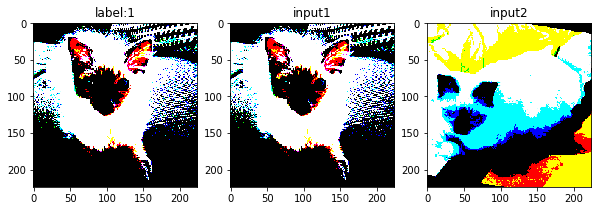

In [47]:
#test image
x, y, t = train_dataset.get_example(0)
print(t)
plt.figure(figsize=(10, 5))
print(x.shape, type(x))

#RGB to BGR
x = x[::-1]
y = y[::-1]

plt.subplot(1, 3, 1)
plt.title('label:{}'.format(t))
plt.imshow(x.transpose(1, 2, 0))

plt.subplot(1, 3, 2)
plt.title('input1')
plt.imshow(x.transpose(1, 2, 0))

plt.subplot(1, 3, 3)
plt.title('input2')
plt.imshow(y.transpose(1, 2, 0))

In [49]:
#SiameseNet based on ResNet model
class SiameseNet(chainer.Chain):
    def __init__(self, dim=256):
        super(SiameseNet, self).__init__()
        with self.init_scope():
            self.resnet = L.ResNet50Layers() 
            self.fc = L.Linear(None, dim)
    
    def forward_once(self, x, train=False):
        h = self.resnet(x, layers=['pool5'])
        y = self.fc(h['pool5'])
        return y
    
    def __call__(self, x_input, y_input, train=False):
        x = self.forward_once(x_input)
        y = self.forward_once(y_input)
        #label = chainer.Variable(t)
        return x, y

In [50]:
model = SiameseNet()

In [51]:
class ContrastiveLoss(chainer.Chain):
    def __init__(self, model):
        super(ContrastiveLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, y, label):
        x_out, y_out = self.model(x, y)
        loss = F.contrastive(x_out, y_out, label)
        
        ''''x0, x1, y = inputs

        self.diff = x_out - y_out  # N x 2
        self.dist_sq = np.sum(self.diff ** 2, axis=1)  # N
        self.dist = np.sqrt(self.dist_sq)
        #self.mdist = self.margin - self.dist
        dist = np.maximum(self.dist, 0)
        loss = label * self.dist_sq + (1 - label) * dist * dist
        loss = np.sum(loss) / 2.0 / x0.shape[0]'''
        
        x_0 = x_out[label==0]
        if len(x_0) > 0:
            loss += F.mean((x_0 ** 2))
        y_0 = y_out[label==0]
        if len(y_0) > 0:
            loss += F.mean((y_0 ** 2))

        chainer.report({'loss': loss}, self)
        return loss

In [52]:
loss = ContrastiveLoss(model)

In [53]:
#train
from chainer import iterators
from chainer import training
from chainer.training import extensions

In [54]:
n_epoch =10  #up to 10
batchsize = 32
out_dir = './result/'
report_interval = (10, 'iteration')

In [55]:
from numba import cuda
cuda.current_context().deallocations.clear()

In [56]:
train_iter = iterators.MultithreadIterator(train_dataset, batchsize, repeat=True, shuffle=True)

In [57]:
optimizer = chainer.optimizers.Adam(alpha=1e-3, amsgrad=True)
optimizer.setup(loss)

In [58]:
updater = training.StandardUpdater(train_iter, optimizer, device=0)#device=0 gpu

In [59]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', trigger=report_interval))

In [60]:
trainer.run()

epoch       iteration   main/loss 
0           10          12.544      
0           20          0.244305    
0           30          0.0870761   
0           40          0.0490973   
0           50          0.0460059   
0           60          0.0387024   
1           70          0.0352553   
1           80          0.0343719   
1           90          0.0361598   
1           100         0.039429    
1           110         0.0321632   
1           120         0.0286479   
2           130         0.0297952   
2           140         0.0311276   
2           150         0.0345539   
2           160         0.0206576   
2           170         0.028302    
2           180         0.0316439   
3           190         0.0256782   
3           200         0.0299099   
3           210         0.0267941   
3           220         0.0240758   
3           230         0.0231444   
3           240         0.0216783   
4           250         0.0195288   
4           260         0.0228039   
4  

In [78]:
from chainer import serializers
MODEL_NAME = './sia_mod'
serializers.save_npz(MODEL_NAME, model)
print('saved successfully')

saved successfully


In [104]:
#evaluation
import cupy as cp
X = []
Y = []
#T = []
for x, y, label in test_dataset:
    #if t != 0 and np.random.random() > 0.01:
    #    continue
    X.append(x)
 #   Y.append(y)
    T.append(label)

X = np.array(X,dtype=np.float32).reshape(-1, 3, 224, 224)
#Y = np.array(Y,dtype=np.float32).reshape(-1, 3, 224, 224)
T = np.array(T,dtype=np.int32)   

X = cp.asarray(X)
#Y = cp.asarray(Y)
T = cp.asarray(T)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [103]:
print(T.size, type(T), X.shape, Y.shape)

AttributeError: 'list' object has no attribute 'shape'

In [92]:
Z = []
for i in range(X.shape[0]):
    temp_x = X[i].reshape(1, 3, 224, 224)
    #fw_x = model.forward_once(temp_x)
    #for j in range(Y.shape[0]):
    #    temp_y = Y[i].reshape(1, 3, 224, 224)
    #    fw_y = model.forward_once(temp_y)
    #    temp = cp.asnumpy(model(fw_x, fw_y).data)
    temp = model.forward_once(temp_x).data
    #temp = cp.asnumpy(model(temp_x, temp_y).data)
    #for j in range(Y.shape[0]):
    #    temp_y = Y[j].reshape(1, 3, 224, 224)
    #    temp = cp.asnumpy(model(temp_x, temp_y).data)
    Z.append(temp)
Z = np.squeeze(np.array(Z, dtype=np.float32))
print(Z.shape)

(5382, 256)


In [102]:
print(Z)

[[ 0.01841583  0.00729796  0.08558629 ... -0.01832616  0.02169156
  -0.04243162]
 [-0.05992686  0.01877908  0.09233091 ... -0.06478901  0.03797043
   0.00292248]
 [-0.27506918  0.08922174  0.09567825 ... -0.08851471  0.07663164
   0.1557853 ]
 ...
 [-0.00035769  0.00964209  0.08918256 ... -0.02150423  0.02339794
  -0.02170608]
 [ 0.01913982  0.00711491  0.08112352 ... -0.02052559  0.02032653
  -0.04206073]
 [-0.01375275  0.00995521  0.08692534 ... -0.02169781  0.03457547
  -0.0201367 ]]


In [93]:
#visualization by tSNE
from sklearn.manifold import TSNE #visualize high-dimentional data

In [94]:
Z_embedded = TSNE(n_components=2).fit_transform(Z)

KeyboardInterrupt: 

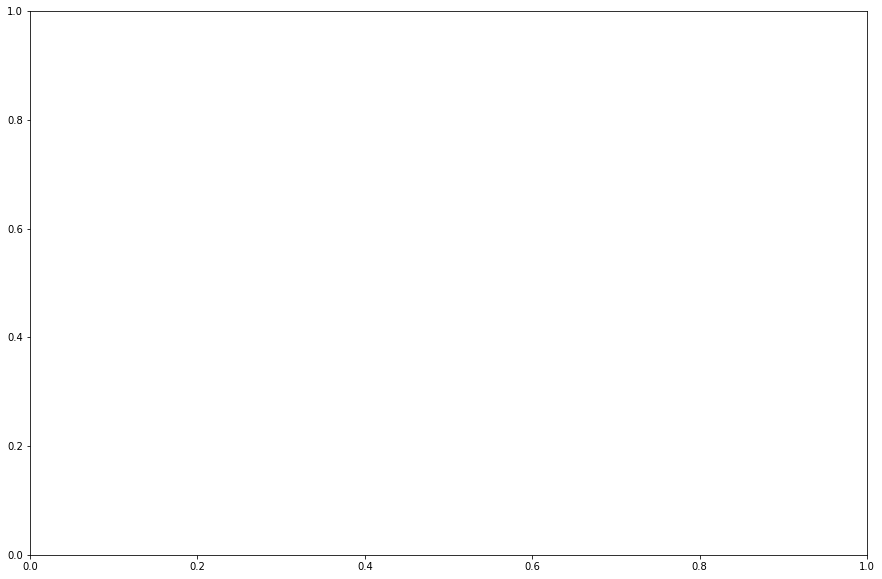

In [95]:
plt.figure(figsize=(15, 10))
plt.scatter(Z_embedded[:, 0], Z_embedded[:,1], c=list(T), cmap='tab10')
plt.colorbar()

In [96]:
#precision recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [97]:
distance_from_origin = np.sqrt(np.sum(Z ** 2, axis=1))

In [98]:
score = distance_from_origin / distance_from_origin.max()
print(score)

[0.15621349 0.20403437 0.6367175  ... 0.15807459 0.14959127 0.16303025]


In [99]:
import chainer.cuda as cd
T = cd.to_cpu(T)

In [100]:
truth = (T != 0)

In [101]:
precision, recall, _ = precision_recall_curve(truth, score)

average_precision = average_precision_score(truth, score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

ValueError: Found input variables with inconsistent numbers of samples: [5234437, 5382]

Text(0.5,1,'2-class Precision-Recall curve: AP=0.00')

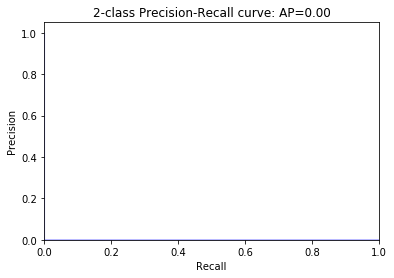

In [51]:
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [52]:
# chance rate
len(T[T!=0]) / len(T)

0.0001858045336306206

In [53]:
(T==0).sum()

5381

In [54]:
precision

array([2.60348867e-04, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00])

In [55]:
recall

array([1., 0., 0., ..., 0., 0., 0.])

In [56]:
precision[recall > 0.999].max()

0.0002603488674824265